<a href="https://colab.research.google.com/github/vorobieva/Day2_RosettaDesign/blob/main/RosettaDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

#Combinatorial sequence design wih Rosetta

Keywords: Bundle, FastDesign, Symmetry

## Overview

In this workshop, we will learn to design the amino acid sequences of alpha-helical bundle backbones generated using Parametric Protein Design. We will then validate and compare the designs based on their Rosetta score and the confidence of the AlphaFold2 predictions.

Please refer to the docs for more info.

https://docs.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/Movers/movers_pages/FastDesignMover

https://docs.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/Movers/movers_pages/SetupForSymmetryMover

In [ ]:
#@title Install and import pyrosetta - the molecular modelling software
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()

In [ ]:
#@title First, we import the necessary Python modules
!pip install py3Dmol
from google.colab import files
import os
import glob
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/google_drive')
pathWD="/content/google_drive/MyDrive/Pavia_course/Day2_RosettaDesign/"

We will work on two de novo designed alpha-helical bundles. Each structure has four parallel helices. One of them was generated with a superhelical twist of -2.45° per residue (left-handed superhelix). The second bundle has a superhelical twist of 0.0° per residue (straight helices). You can load the structures in the 3D visual tool below to compare them.

**Which one do you think loos more "natural"?**

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol

show_sidechains = True #@param {type:"boolean"}
color = "chain" #@param ["chain", "rainbow"]
model = "coiled" #@param ["coiled", "straight"]

view=py3Dmol.view()

def show_pdb(show_sidechains=False, color="chain", model="coiled"):

  if model == "coiled":
    view.addModel(open(pathWD+'coiled.pdb', 'r').read(),'pdb')
  elif model == "straight":
    view.addModel(open(pathWD+'straight.pdb', 'r').read(),'pdb')

  view.setBackgroundColor('white')

  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = 4
    pymol_color_list = ['skyblue', 'yellow', 'green', 'magenta', 'white', 'salmon']
    alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F']

    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(show_sidechains, color, model).show()

# Working with symmetry

Can you explain with your own words the difference between the two structures? Which one has the highest chances to yield a **well-packed hyrdophobic core**?

Another clear feature of the structures is their **4-fold symmetry** (one helix is copied three time along a C4 symmetry axis). We will use the symmetry for sequence design calculations.

In [ ]:
#@title The code below generates a symmetry definition file for each input PDB
pdbs = ["coiled", "straight"]
for pdb in pdbs:
  base_cmd = f'make_symmdef_file.pl -r 10 -m NCS -p  {pdb}.pdb > input/{pdb}.symm '
  print(base_cmd)

In [ ]:
#@title Let's take a look at the content of the symmetry definition file. It contains intructions for the transfomation in 3D space of the coordinates of the helix in chainA to generate the other helices
with open(pathWD+"precomputed_results/coiled.symm", 'r') as f:
  for line in f:
    print(line)

In [ ]:
#@title Let's take the helix in chainA only, apply the symmetry definition and see how it affects the score.
coilPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/coiled_INPUT.pdb")
original = coilPose.clone()
symmetrize = pyrosetta.rosetta.protocols.symmetry.SetupForSymmetryMover(pathWD+"precomputed_results/coiled.symm")
symmetrize.apply(original)

scorefxn = pyrosetta.get_score_function()
input_score = scorefxn(coilPose)
print("\nInput State Score (monomer): ",input_score,"\n")
output_score = scorefxn(original)
print("\nSymmetrized State Score (teramer): ",output_score,"\n")


In [ ]:
#@title The code below runs the combinatorial sequence design protocol for the coiled backbone. **Output will be located in the OUTPUT folder on your Google Drive.**

original = coilPose.clone()
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
	          <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
	          <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
	          <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
	          <SecondaryStructure name="sheet" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="E"/>
	          <SecondaryStructure name="loop" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="L"/>
	          <SecondaryStructure name="helix" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="H"/>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
	          <DesignRestrictions name="layer_design">
		          <Action selector_logic="surface AND helix"		aas="EHKQR"/>
		          <Action selector_logic="surface AND sheet"		aas="EHKNQRST"/>
		          <Action selector_logic="surface AND loop"		aas="DEGHKNPQRST"/>
		          <Action selector_logic="boundary AND helix"		aas="ADEHIKLMNQRSTVWY"/>
		          <Action selector_logic="boundary AND sheet"		aas="DEFHIKLMNQRSTVWY"/>
		          <Action selector_logic="boundary AND loop"		aas="ADEFGHIKLMNPQRSTVWY"/>
		          <Action selector_logic="core AND helix"			aas="AFILMVWY"/>
		          <Action selector_logic="core AND sheet"			aas="FILMVWY"/>
		          <Action selector_logic="core AND loop"			aas="AFGILMPVWY"/>
	          </DesignRestrictions>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <SetupForSymmetry name="setup_symm" set_global_symmetry_at_parsetime="1" definition="/content/google_drive/MyDrive/Pavia_course/Day2_RosettaDesign/precomputed_results/coiled.symm" preserve_datacache="1" keep_pdb_info_labels="1" />
           <FastDesign name="fdesign" task_operations="layer_design" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover= "setup_symm"/>
           <Add mover="fdesign" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
xml.apply(original)
original.dump_pdb(pathWD+'outputs/coiled_001.pdb')

In [ ]:
#@title Now let's run the combinatorial sequence design for the straight backbone. **Output will be located in the OUTPUT folder on your Google Drive**.
straightPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/straight_INPUT.pdb")
original = straightPose.clone()
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
	          <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
	          <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
	          <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
	          <SecondaryStructure name="sheet" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="E"/>
	          <SecondaryStructure name="loop" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="L"/>
	          <SecondaryStructure name="helix" overlap="0" minH="1" minE="1" include_terminal_loops="true" use_dssp="true" ss="H"/>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
	          <DesignRestrictions name="layer_design">
		          <Action selector_logic="surface AND helix"		aas="EHKQR"/>
		          <Action selector_logic="surface AND sheet"		aas="EHKNQRST"/>
		          <Action selector_logic="surface AND loop"		aas="DEGHKNPQRST"/>
		          <Action selector_logic="boundary AND helix"		aas="ADEHIKLMNQRSTVWY"/>
		          <Action selector_logic="boundary AND sheet"		aas="DEFHIKLMNQRSTVWY"/>
		          <Action selector_logic="boundary AND loop"		aas="ADEFGHIKLMNPQRSTVWY"/>
		          <Action selector_logic="core AND helix"			aas="AFILMVWY"/>
		          <Action selector_logic="core AND sheet"			aas="FILMVWY"/>
		          <Action selector_logic="core AND loop"			aas="AFGILMPVWY"/>
	          </DesignRestrictions>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <SetupForSymmetry name="setup_symm" set_global_symmetry_at_parsetime="1" definition="/content/google_drive/MyDrive/Pavia_course/Day2_RosettaDesign/precomputed_results/straight.symm" preserve_datacache="1" keep_pdb_info_labels="1" />
           <FastDesign name="fdesign" task_operations="layer_design" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover= "setup_symm"/>
           <Add mover="fdesign" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
xml.apply(original)
original.dump_pdb(pathWD+'outputs/straight_001.pdb')

In [ ]:
#@title Let's display the 3D structures with the sidechains {run: "auto"}
import py3Dmol

show_sidechains = True #@param {type:"boolean"}
color = "chain" #@param ["chain", "rainbow"]
model = "straight" #@param ["coiled", "straight"]

view=py3Dmol.view()

def show_pdb(show_sidechains=False, color="chain", model="coiled"):

  if model == "coiled":
    view.addModel(open(pathWD+'precomputed_results/coiled_001.pdb', 'r').read(),'pdb')
  elif model == "straight":
    view.addModel(open(pathWD+'precomputed_results/straight_001.pdb', 'r').read(),'pdb')

  view.setBackgroundColor('white')

  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = 4
    pymol_color_list = ['skyblue', 'yellow', 'green', 'magenta', 'white', 'salmon']
    alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F']

    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(show_sidechains, color, model).show()

What do you see? Did the structures change?

A: The straight helices have moved and started to slightly coil around the superhelical axis. This is due to the fact that FastDesign is a flexible backbone design protocol - it allows protein backbone movement during the minimization steps.

In [ ]:
#@title Let's compare the total scores of the coiled and straight structures before/after combinatorial sequence design {run: "auto"}
coiledPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/coiled_INPUT.pdb")
straightPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/straight_INPUT.pdb")

coiledDPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/coiled_001.pdb")
straightDPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/straight_001.pdb")
symmetrizeC = pyrosetta.rosetta.protocols.symmetry.SetupForSymmetryMover(pathWD+"precomputed_results/coiled.symm")
symmetrizeS = pyrosetta.rosetta.protocols.symmetry.SetupForSymmetryMover(pathWD+"precomputed_results/straight.symm")
symmetrizeC.apply(coiledPose)
symmetrizeS.apply(straightPose)

scorefxn = pyrosetta.get_score_function()

input_scoreC = scorefxn(coiledPose)
print("\nTotal Score Coiled Monomer: ",input_scoreC,"\n")
output_scoreC = scorefxn(coiledDPose)
print("\nTotal Score Coiled Symmetrized: ",output_scoreC,"\n")

input_scoreS = scorefxn(straightPose)
print("\nTotal Score Coiled Monomer: ",input_scoreS,"\n")
output_scoreS = scorefxn(straightDPose)
print("\nTotal Score Coiled Symmetrized: ",output_scoreS,"\n")

In [ ]:
#@title Printing score breakdown of the coiled helix design
scorefxn.show(coiledDPose)

In [ ]:
#@title Printing score breakdown of the straight helix design
scorefxn.show(straightDPose)

Which design is the best (lowest score)? Which score terms contribute to lower/higher energy?

*Answer*

**fa_sol** Solvation energy (interaction with water)

**fa_elec** Electrostatic interactions

**hbond_sr_bb** Backbone-backbone hydrogen bonds in an alpha-helix

**hbind_sc** Sidechain-sidechain hydrogen bonds

**omega** Planarity of the peptide bond

**fa_dun** Sidechain conformations (more favorable == more frequent in the PDB)

Now, let's validate the sequences using AlphaFold structure prediction. First, we need to obtain the sequences of the designs using the code below. Remember that Rosetta is NOT deterministic. It is possible that the sequences of your designs are somewhat different from mine. They might also change if your run the design calculations several times. However, for this exercise, the notebook will open pre-computed models, not the models you just generated!!

In [ ]:
print("Sequence of one coiled helix: "+coiledDPose.chain_sequence(1))

In [ ]:
print("Sequence of one straight helix: "+straightDPose.chain_sequence(1))

Open the AlphaFold colab notebook (https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).

Paste a sequence above four times in the *sequence_query* filed, separated by ":". For example:
PAEEELKELLKRLEKLLHEIIEILRKLS**:**PAEEELKELLKRLEKLLHEIIEILRKLS**:**PAEEELKELLKRLEKLLHEIIEILRKLS**:**PAEEELKELLKRLEKLLHEIIEILRKLS

Change the *msa_mode* to *single_sequence* and the *model_type* to *AlphaFold2_multimer_v3*. Run the prediction. Can you interpret the result yourself?

For my designs, the pLDDT and pAE scores of the coiled design are much better than the scores of the straight design. WHY??

Coiled design:
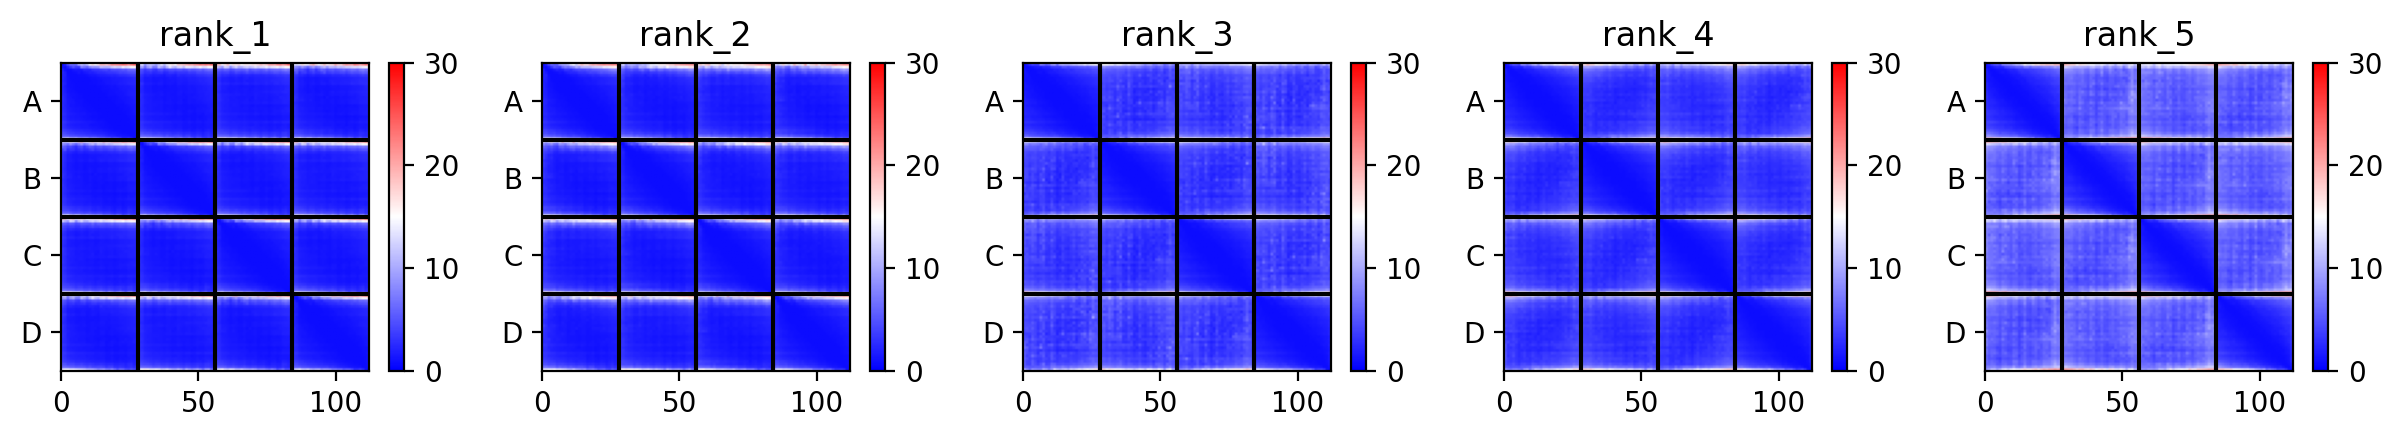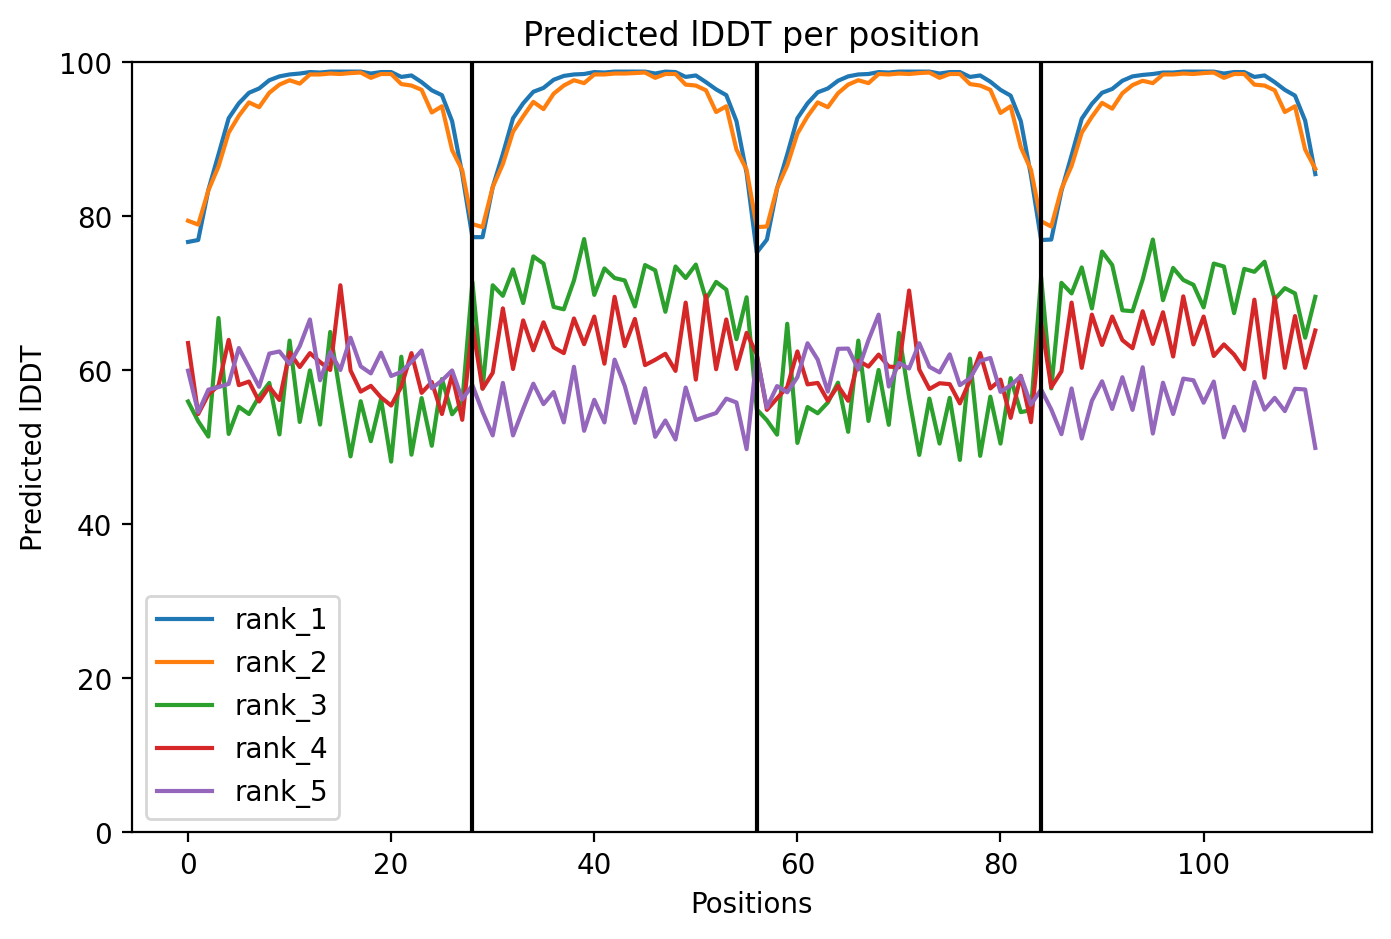

Straight design:
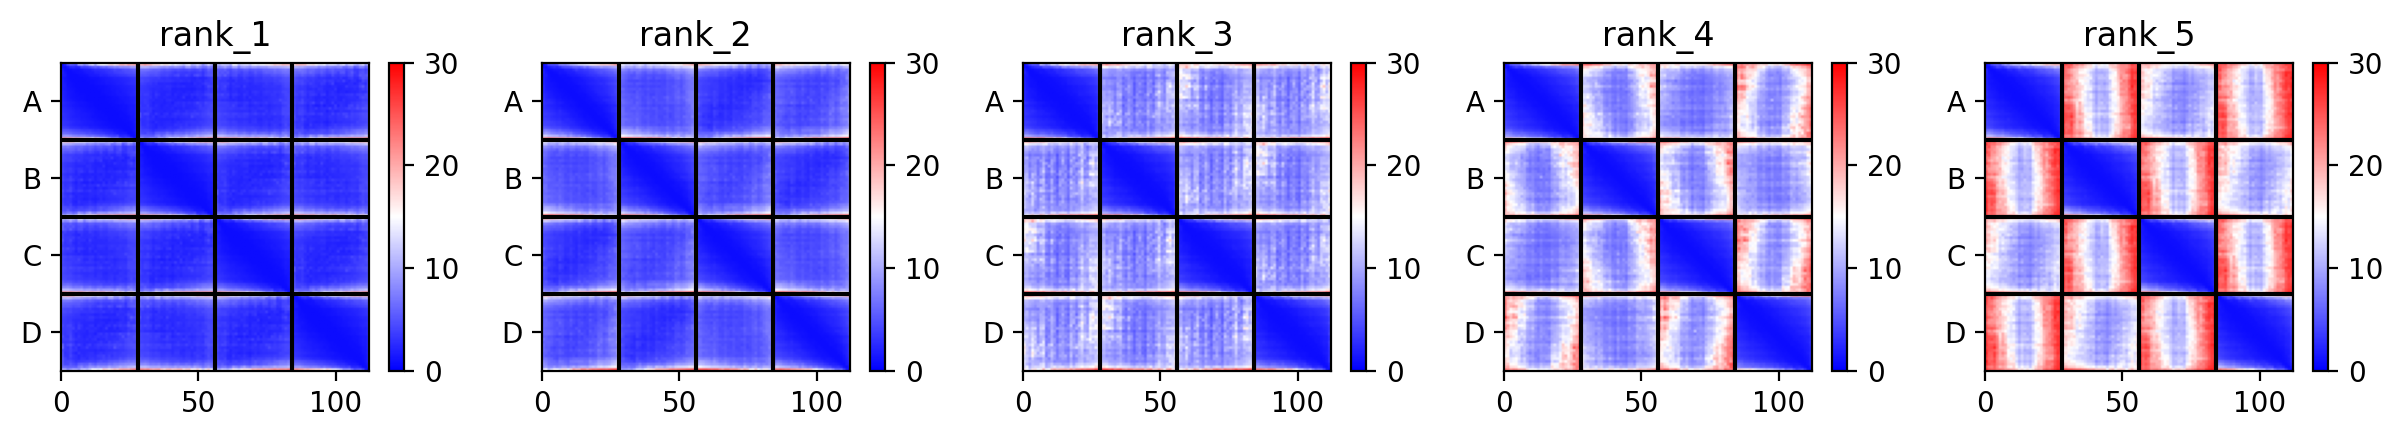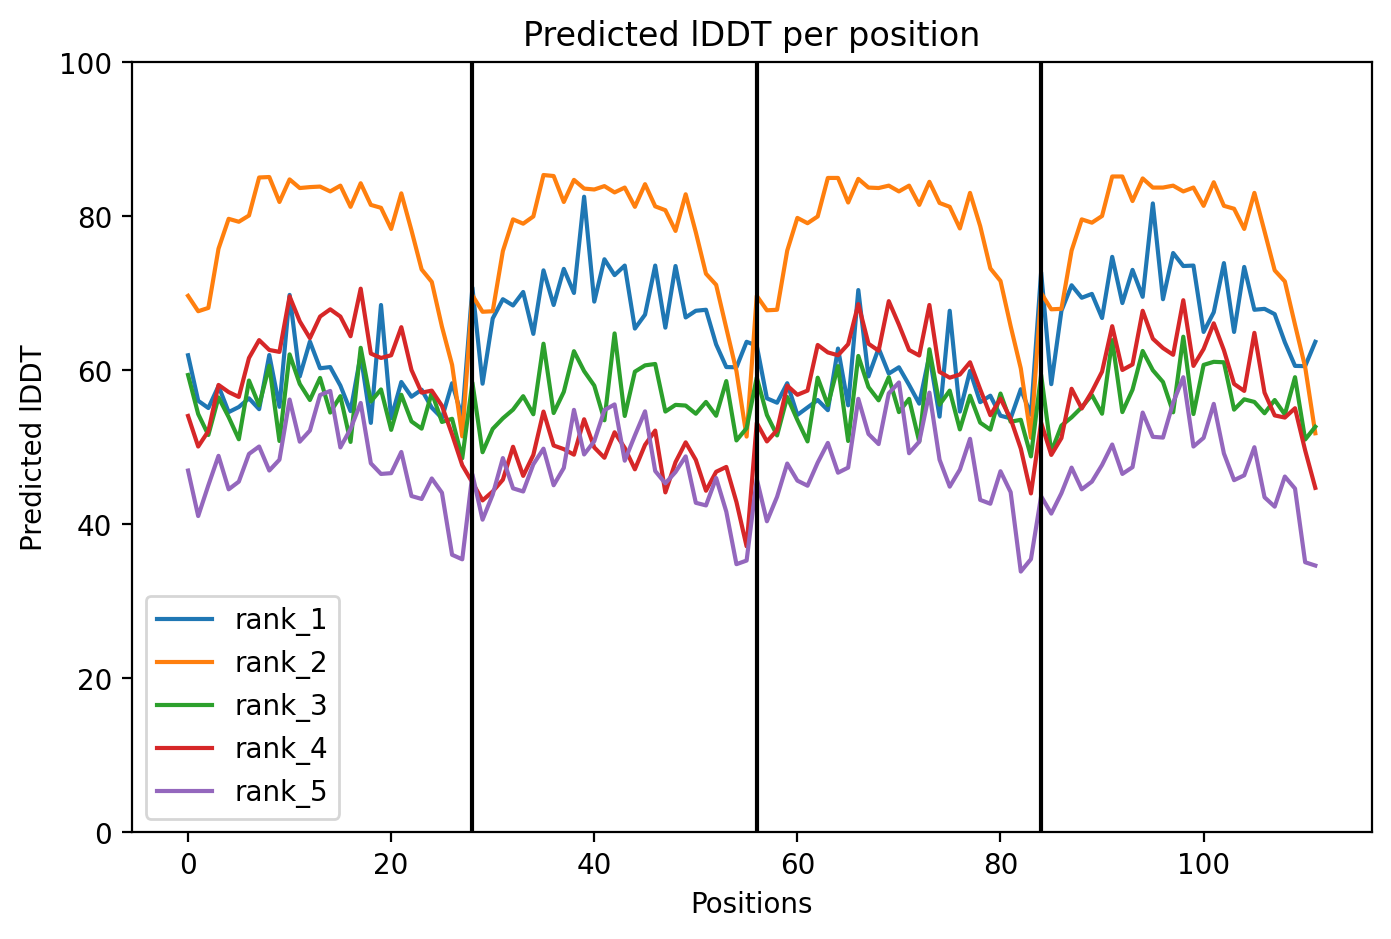


In [ ]:
#@title Let's display the 3D structures with the sidechains {run: "auto"}
import py3Dmol

show_sidechains = True #@param {type:"boolean"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
model = "coiled" #@param ["coiled", "straight"]

view=py3Dmol.view()

def show_pdb(show_sidechains=False, color="lDDT", model="coiled"):

  if model == "coiled":
    view.addModel(open(pathWD+'precomputed_results/coiled_rank_001_alphafold2_multimer_v3_model_2_seed_000.pdb', 'r').read(),'pdb')
  elif model == "straight":
    view.addModel(open(pathWD+'precomputed_results/straight_rank_001_alphafold2_multimer_v3_model_3_seed_000.pdb', 'r').read(),'pdb')

  view.setBackgroundColor('white')

  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "chain":
    chains = 4
    pymol_color_list = ['skyblue', 'yellow', 'green', 'magenta', 'white', 'salmon']
    alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F']

    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(show_sidechains, color, model).show()

#Visualization exercise:

Let's download the PDBs and use Pymol to make nice images highlighting the following features of the designs:

- The general structure of the design and of the predicted AlphaFold2 model. How do they compare?

- The local confidence (pLDDT) of the AlphaFold2 models. Select *color* --> *spectrum* --> *bfactors*. BONUS: try to change the color palette.

- The hydrophobic packing in the core of the designs. Try to highlight potential cavities (*show* --> *mesh*).

- The hydrogen bonds and other polar contacts (*action* --> *find* --> *polar contacts*).

#Conclusion

The helical parameters used to generate the protein backbones define whether the backbones will be "designable". Designable backbones will support better sidechain packing, interactions, and produce designs wth lower scores.